In [1]:
#!/usr/bin/env python3
import os, sys
import wget
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt

from datetime import datetime, date
from collections import Counter
import math
#from scipy import interpolate
# import seawater as sw
# from scipy.interpolate import interp1d

In [2]:
def str2num_noneg(str_in):    
    try:
        # Convert the input string to a float
        num = float(str_in)

        # Check if the number is nonnegative
        if num >= 0:
            return num
        else:
            return float('nan')
    except ValueError:
        # Return NaN if the input contains non-numeric characters
        return float('nan')

In [3]:
def date_to_days(date_str, reference_date_str="01.11.19"):
    # Define the format for the input date string
    date_format = "%d.%m.%y"

    try:
        # Parse the input date string and the reference date string to datetime objects
        date_obj = datetime.strptime(date_str, date_format)
        reference_date_obj = datetime.strptime(reference_date_str, date_format)

        # Calculate the difference in days between the two dates
        days_difference = (date_obj - reference_date_obj).days

        return days_difference
    except ValueError:
        # Return None if there's an error parsing the date strings
        return None

In [4]:
def mean_of_unique_dates(dates_list, data_array):
    # Create a Counter object to count the occurrences of each date
    date_counts = Counter(dates_list)    
    unique_dates, unique_indices = np.unique(dates_list, return_index=True)    
    mean_values = []
    
    for date, idx in zip(unique_dates, unique_indices):
        count = date_counts[date]
        data_slice = data_array[dates_list.index(date, idx, len(dates_list))]
        mean = np.mean(data_slice) if count == 1 else np.mean(data_slice) * count
        mean_values.append(mean)

    return unique_dates, np.array(mean_values)

In [5]:
REcoM1D_mesh = xr.open_dataset("../data/MESH/REcoM1D_mesh.nc")

In [6]:
mod_depths = REcoM1D_mesh.Z.values
mod_depths_bound = REcoM1D_mesh.zbar.values
mod_depths_bound

array([ 0.00e+00, -5.00e+00, -1.00e+01, -2.00e+01, -3.00e+01, -4.00e+01,
       -5.00e+01, -6.00e+01, -7.00e+01, -8.00e+01, -9.00e+01, -1.00e+02,
       -1.15e+02, -1.35e+02, -1.60e+02, -1.90e+02, -2.30e+02, -2.80e+02,
       -3.40e+02, -4.10e+02, -4.90e+02, -5.80e+02, -6.80e+02, -7.90e+02,
       -9.10e+02, -1.04e+03, -1.18e+03, -1.33e+03, -1.50e+03, -1.70e+03,
       -1.92e+03, -2.15e+03, -2.40e+03, -2.65e+03, -2.90e+03, -3.15e+03,
       -3.40e+03, -3.65e+03, -3.90e+03, -4.15e+03, -4.40e+03, -4.65e+03,
       -4.90e+03, -5.15e+03, -5.40e+03, -5.65e+03, -6.00e+03, -6.25e+03])

In [7]:
chl_file = '../data/CHLA/MOSAiC_Chla_forLaurent_20220905.xlsx'

In [8]:
from pandas import read_excel
chl_df = read_excel(chl_file, sheet_name = 'CTDs')
print(chl_df.head())

  TEAM mosaic_leg  mosaic_week  Cast Station_Device_Operation  \
0  ECO    PS122/1            5    40             PS122/1_5-40   
1  ECO    PS122/1            5    40             PS122/1_5-40   
2  ECO    PS122/1            5    40             PS122/1_5-40   
3  ECO    PS122/1            5    40             PS122/1_5-40   
4  ECO    PS122/1            5    40             PS122/1_5-40   

   EcoOmics_time_serie       Date  time_utc time_start          device  ...  \
0                False 2019-10-31  04:34:00        NaN  Ocean City CTD  ...   
1                False 2019-10-31  04:34:00        NaN  Ocean City CTD  ...   
2                False 2019-10-31  04:34:00        NaN  Ocean City CTD  ...   
3                False 2019-10-31  04:34:00        NaN  Ocean City CTD  ...   
4                False 2019-10-31  04:34:00        NaN  Ocean City CTD  ...   

    sample_label  varibale_volume_ml  Chl[µg L-1]  Unnamed: 39 Unnamed: 40  \
0  PS122_Chl_026                 790     0.076001       

In [9]:
chl_date = chl_df['Date']
chl_depth = chl_df['desired_depth']
chla_data = chl_df['Chl[µg L-1]']

In [10]:
def date_to_step(date, reference_date=np.datetime64('2019-04-15')):
    # Convert the date and reference_date to numpy datetime64 objects if they are not already
    date = np.datetime64(date)
    reference_date = np.datetime64(reference_date)

    # Calculate the difference in days between the date and the reference_date
    days_difference = (date - reference_date).astype('timedelta64[D]').item().days
    time_step = days_difference * 48

    return time_step

In [11]:
unique_date_ch = np.unique(chl_date)
unique_date_ch.shape

(49,)

In [12]:
for i in range(len(unique_date_ch)):
    print(unique_date_ch[i])

2019-10-31T00:00:00.000000000
2019-11-02T00:00:00.000000000
2019-11-08T00:00:00.000000000
2019-11-14T00:00:00.000000000
2019-11-21T00:00:00.000000000
2019-11-28T00:00:00.000000000
2019-12-05T00:00:00.000000000
2019-12-26T00:00:00.000000000
2020-01-02T00:00:00.000000000
2020-01-09T00:00:00.000000000
2020-01-16T00:00:00.000000000
2020-01-20T00:00:00.000000000
2020-01-23T00:00:00.000000000
2020-01-30T00:00:00.000000000
2020-02-07T00:00:00.000000000
2020-02-20T00:00:00.000000000
2020-03-05T00:00:00.000000000
2020-03-06T00:00:00.000000000
2020-03-12T00:00:00.000000000
2020-03-14T00:00:00.000000000
2020-03-22T00:00:00.000000000
2020-03-27T00:00:00.000000000
2020-04-04T00:00:00.000000000
2020-04-05T00:00:00.000000000
2020-04-09T00:00:00.000000000
2020-04-17T00:00:00.000000000
2020-04-23T00:00:00.000000000
2020-04-30T00:00:00.000000000
2020-05-07T00:00:00.000000000
2020-05-16T00:00:00.000000000
2020-06-16T00:00:00.000000000
2020-06-27T00:00:00.000000000
2020-07-01T00:00:00.000000000
2020-07-03

In [13]:
chl_steps = np.zeros_like(chla_data)
for i in range(len(chl_date)):
    chl_steps[i] = date_to_step(chl_date[i])

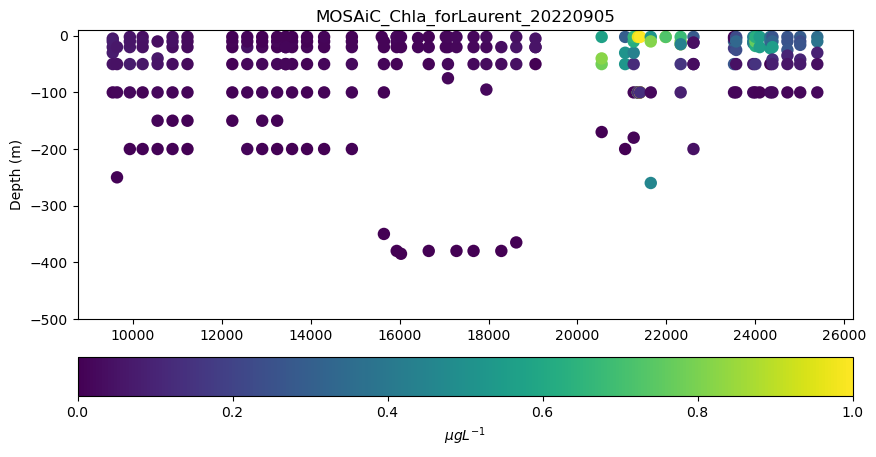

In [14]:
plt.rcParams["figure.figsize"] = (10,5) 
plt.scatter(chl_steps, -chl_depth,s=80, c=chla_data, marker='o', edgecolor='none')

plt.ylim((-500, 10))
plt.clim(0, 1)
cbar = plt.colorbar(orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel(r'$µg L^{-1}$')
plt.title('MOSAiC_Chla_forLaurent_20220905')
plt.ylabel('Depth (m)')
plt.show()

In [15]:
chla_rmsd = chla_data* 0.3
# chla_rmsd

In [16]:
chla_data_logtrans = np.zeros_like(chla_data)
chla_rmsd_logtrans = np.zeros_like(chla_data)
for i in range(len(chla_data)):
    if chla_data[i]==0:
        chla_val = 1.0e-10
        chla_err = 1.0e-10 * 0.3 
        chla_data_logtrans[i] = math.log(chla_val) - 0.5 * math.log(1 + (chla_err**2 / chla_val**2))
        chla_rmsd_logtrans[i] = math.sqrt(math.log(1 + (chla_err**2 / chla_val**2)))
    else:
        chla_val = chla_data[i]
        chla_err = chla_data[i] * 0.3 
        chla_data_logtrans[i] = math.log(chla_val) - 0.5 * math.log(1 + (chla_err**2 / chla_val**2))
        chla_rmsd_logtrans[i] = math.sqrt(math.log(1 + (chla_err**2 / chla_val**2)))

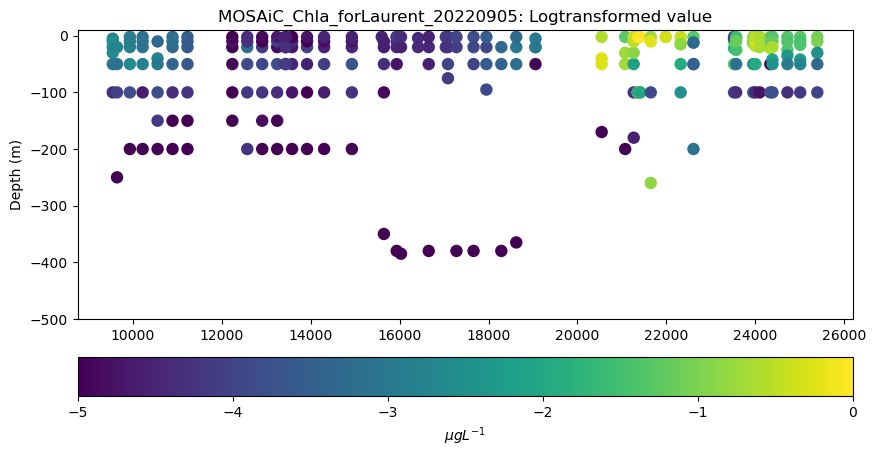

In [17]:
plt.rcParams["figure.figsize"] = (10,5) 
plt.scatter(chl_steps, -chl_depth,s=80, c=chla_data_logtrans, marker='o', edgecolor='none')

plt.ylim((-500, 10))
plt.clim(-5, 0)
cbar = plt.colorbar(orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel(r'$µg L^{-1}$')
plt.title('MOSAiC_Chla_forLaurent_20220905: Logtransformed value')
plt.ylabel('Depth (m)')
plt.show()

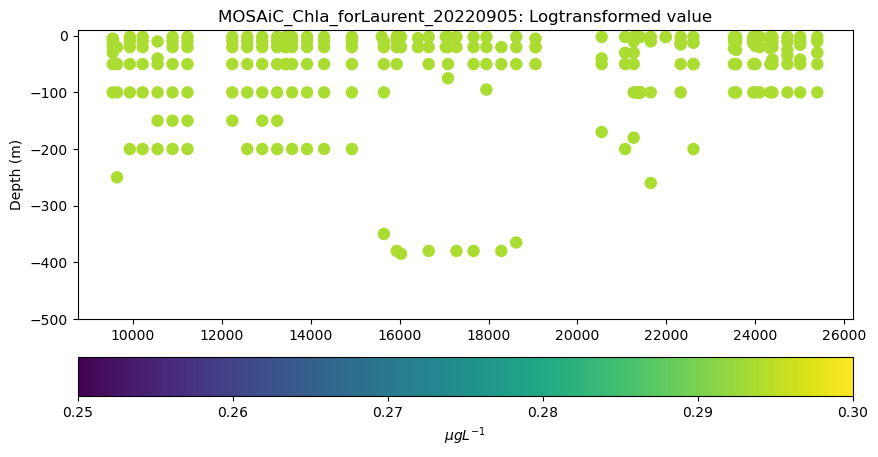

In [18]:
plt.rcParams["figure.figsize"] = (10,5) 
plt.scatter(chl_steps, -chl_depth,s=80, c=chla_rmsd_logtrans, marker='o', edgecolor='none')

plt.ylim((-500, 10))
plt.clim(0.25, 0.3)
cbar = plt.colorbar(orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel(r'$µg L^{-1}$')
plt.title('MOSAiC_Chla_forLaurent_20220905: Logtransformed value')
plt.ylabel('Depth (m)')
plt.show()

In [19]:
unique_chl_steps = []
unique_indices_dict = {}
for index, item in enumerate(chl_steps):
    if item not in unique_indices_dict:
        unique_chl_steps.append(item)
        unique_indices_dict[item] = [index]
    else:
        unique_indices_dict[item].append(index)

unique_chl_steps = np.array(unique_chl_steps)

print(unique_chl_steps)

[ 9552.  9648.  9936. 10224. 10560. 10896. 11232. 12240. 12576. 12912.
 13248. 13440. 13584. 13920. 14304. 14928. 15648. 15600. 15936. 16032.
 16416. 16656. 17040. 17088. 17280. 17664. 17952. 18288. 18624. 19056.
 20544. 21072. 21264. 21360. 21408. 21648. 21984. 22320. 22608. 23520.
 23568. 23952. 24000. 24096. 24336. 24384. 24720. 25008. 25392.]


In [20]:
unique_indices_dict[unique_chl_steps[2]]

[10, 11, 12, 13, 14, 15]

In [21]:
chl_data_2d = np.zeros((len(unique_chl_steps),20))
chl_data_2d = chl_data_2d - 99.99
depth_bin = mod_depths_bound * -1

In [22]:
for row in range(len(unique_chl_steps)):
    
    depths = np.array(chl_depth[unique_indices_dict[unique_chl_steps[row]]])    
    data = np.array(chla_data[unique_indices_dict[unique_chl_steps[row]]])
    
    
    for col in range(20):
        depth_range_min = depth_bin[col]
        depth_range_max = depth_bin[col + 1]
        data_in_range = [data[i] for i in range(len(depths)) if depth_range_min <= depths[i] < depth_range_max]
        
        if data_in_range:
            chl_data_2d[row,col] = np.mean(data_in_range)

In [23]:
spin_up_time = 200
delta_day = 48
obs_steps = unique_chl_steps + 24
obs_steps = obs_steps.astype(int)
obs_steps

array([ 9576,  9672,  9960, 10248, 10584, 10920, 11256, 12264, 12600,
       12936, 13272, 13464, 13608, 13944, 14328, 14952, 15672, 15624,
       15960, 16056, 16440, 16680, 17064, 17112, 17304, 17688, 17976,
       18312, 18648, 19080, 20568, 21096, 21288, 21384, 21432, 21672,
       22008, 22344, 22632, 23544, 23592, 23976, 24024, 24120, 24360,
       24408, 24744, 25032, 25416])

In [24]:
sorted_indices = np.argsort(obs_steps)
sorted_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [25]:
sorted_obs_steps = obs_steps[sorted_indices]

In [26]:
print(sorted_obs_steps[1:] - sorted_obs_steps[:-1])

[  96  288  288  336  336  336 1008  336  336  336  192  144  336  384
  624  672   48  288   96  384  240  384   48  192  384  288  336  336
  432 1488  528  192   96   48  240  336  336  288  912   48  384   48
   96  240   48  336  288  384]


In [27]:
sorted_chl_data_2d = chl_data_2d[sorted_indices]
print(sorted_chl_data_2d.shape)

(49, 20)


In [28]:
chl_data_2d = chl_data_2d.astype(np.float64)
#chl_data_2d

In [29]:
chl_da = xr.DataArray(sorted_chl_data_2d, dims=("step", "depth"), coords={"step": sorted_obs_steps, "depth": mod_depths[ :20].astype(np.float64)})

# Add units for variables
chl_da.attrs["units"] = "µg L^-1"

# Create a Dataset and add the DataArray to it
dataset = xr.Dataset({"Chl_a": chl_da})
dataset

<xarray.Dataset>
Dimensions:  (step: 49, depth: 20)
Coordinates:
  * step     (step) int64 9576 9672 9960 10248 10584 ... 24408 24744 25032 25416
  * depth    (depth) float64 -2.5 -7.5 -15.0 -25.0 ... -310.0 -375.0 -450.0
Data variables:
    Chl_a    (step, depth) float64 -99.99 0.06981 0.08068 ... -99.99 -99.99

In [30]:
dataset.attrs["description"] = "MOSAiC_Chla_forLaurent_20220905 with dimensions step and depth"
dataset.attrs["history"] = "MOSAiC_Chla_forLaurent_20220905"
dataset

<xarray.Dataset>
Dimensions:  (step: 49, depth: 20)
Coordinates:
  * step     (step) int64 9576 9672 9960 10248 10584 ... 24408 24744 25032 25416
  * depth    (depth) float64 -2.5 -7.5 -15.0 -25.0 ... -310.0 -375.0 -450.0
Data variables:
    Chl_a    (step, depth) float64 -99.99 0.06981 0.08068 ... -99.99 -99.99
Attributes:
    description:  MOSAiC_Chla_forLaurent_20220905 with dimensions step and depth
    history:      MOSAiC_Chla_forLaurent_20220905

In [31]:
output_file = "../data/MOSAiC_Chla_forLaurent_20220905.nc"
dataset.to_netcdf(output_file, format="NETCDF4")
print(f"Chl-a data has been written to {output_file}.")

PermissionError: [Errno 13] Permission denied: b'/albedo/work/user/nmamnun/nuarctic/data/MOSAiC_Chla_forLaurent_20220905.nc'

In [ ]:
MOSAiC_Chla = xr.open_dataset("../data/MOSAiC_Chla_forLaurent_20220905.nc")
MOSAiC_Chla

In [ ]:
MOSAiC_Chla.step.values

In [ ]:
MOSAiC_Chla.close()